In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import gzip
import requests
from collections import OrderedDict

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(42)

#아래 함수가 작도되지 않을때 사용 x의 shape이 다릅니다.
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()



def download_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

def load_mnist(kind='train'):
    base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com"
    file_dict = {
        'train': ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz'],
        'test': ['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
    }

    images_file, labels_file = file_dict[kind]

    # 이미지 파일 확인 및 다운로드
    if not os.path.exists(images_file):
        download_file(os.path.join(base_url, images_file), images_file)
    with gzip.open(images_file, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(-1, 784)

    # 레이블 파일 확인 및 다운로드
    if not os.path.exists(labels_file):
        download_file(os.path.join(base_url, labels_file), labels_file)
    with gzip.open(labels_file, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    return images, labels
#정규화
def normalization(x_train,x_test):
  x_train = x_train.astype(np.float32) / 255.0
  x_test = x_test.astype(np.float32) / 255.0
#원핫 인코딩
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.shape[0], num_classes))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1.0
    return one_hot
#무작위 섞기
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    return x[indices], y[indices]

간단한 분석


(60000, 784)


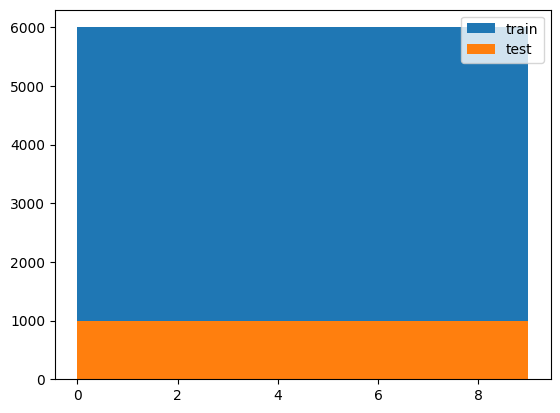

In [2]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
#x_train, y_train = load_mnist(kind='train')
#x_test, y_test = load_mnist(kind='test')
print(x_train.shape)
plt.hist(y_train,label="train")
plt.hist(y_test,label='test')
plt.legend()
plt.show()

## 전처리

In [3]:
#정규화
normalization(x_train,x_test)
#셔플(1에폭 마다 실행하는걸로 수정했습니다.)
x_train, y_train = shuffle_data(x_train, y_train)
#원핫 인코딩
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

## Function

In [4]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)



## Layers

In [5]:
# coding: utf-8
import numpy as np

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None  # 손실함수
        self.y = None     # softmax의 출력
        self.t = None     # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        if t.ndim == 2:  # if t is one-hot encoded
            t = t.argmax(axis=1)

        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


## Optimizer

In [6]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## Gradient

In [7]:
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

## Trainer

## Multilayer

In [8]:
# class MultiLayerNet:
#     def __init__(self, layer_sizes, weight_init_std=0.01, use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
#         self.params = {}
#         self.layers = OrderedDict()
#         self.use_dropout = use_dropout
#         self.use_batchnorm = use_batchnorm
#         self.dropout_ratio = dropout_ratio

#         num_layers = len(layer_sizes)
#         for i in range(1, num_layers):
#             #std
#             #self.params['W' + str(i)] = weight_init_std * np.random.randn(layer_sizes[i-1], layer_sizes[i])
#             #HE

#             self.params['b' + str(i)] = np.zeros(layer_sizes[i])

#             self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])

#             if use_batchnorm and i < num_layers - 1:  # 마지막 레이어 전까지만 배치 정규화 적용
#                 self.params['gamma' + str(i)] = np.ones(layer_sizes[i])
#                 self.params['beta' + str(i)] = np.zeros(layer_sizes[i])
#                 self.layers['BatchNorm' + str(i)] = BatchNormalization(self.params['gamma' + str(i)], self.params['beta' + str(i)])

#             if i < num_layers - 1:  # 마지막 레이어 전까지만 ReLU 적용
#                 self.layers['Relu' + str(i)] = Relu()
#                 if use_dropout:  # 드롭아웃 적용
#                     self.layers['Dropout' + str(i)] = Dropout(dropout_ratio)

#         self.lastLayer = SoftmaxWithLoss()

#     def predict(self, x):
#         for layer in self.layers.values():
#             x = layer.forward(x)
#         return x

#     def loss(self, x, t):
#         y = self.predict(x)
#         return self.lastLayer.forward(y, t)

#     def accuracy(self, x, t):
#         y = self.predict(x)

#         y = np.argmax(y, axis=1)
#         if t.ndim != 1: t = np.argmax(t, axis=1)
#         accuracy = np.sum(y == t) / float(x.shape[0])
#         return accuracy

#     def accuracy_per_class(self, X, Y):
#         predictions = self.predict(X)
#         true_labels = np.argmax(Y, axis=1)
#         unique_labels = np.unique(true_labels)

#         accuracy = {}
#         for label in unique_labels:
#             idx = true_labels == label
#             accuracy[label] = np.sum(predictions[idx] == true_labels[idx]) / np.sum(idx)

#         return accuracy

#     def numerical_gradient(self, x, t):
#         loss_W = lambda W: self.loss(x, t)
#         grads = {}
#         for idx, key in enumerate(self.params):
#             grads[key] = numerical_gradient(loss_W, self.params[key])
#         return grads


#     def gradient(self, x, t):
#         # 순전파
#         self.loss(x, t)

#         # 역전파
#         dout = 1
#         dout = self.lastLayer.backward(dout)

#         layers = list(self.layers.values())
#         layers.reverse()
#         for layer in layers:
#             dout = layer.backward(dout)

#         # 결과 저장
#         grads = {}
#         affine_idx = 1  # Affine 레이어에 대한 인덱스를 추적합니다.
#         for key, layer in self.layers.items():
#             if 'Affine' in key:
#                 grads['W' + str(affine_idx)] = layer.dW
#                 grads['b' + str(affine_idx)] = layer.db
#                 affine_idx += 1  # 다음 Affine 레이어로 인덱스를 증가시킵니다.

#             if 'BatchNorm' in key and self.use_batchnorm and affine_idx > 1:  # 첫 번째 레이어는 BatchNorm 레이어가 아닙니다.
#                 grads['gamma' + str(affine_idx - 1)] = layer.dgamma
#                 grads['beta' + str(affine_idx - 1)] = layer.dbeta

#         return grads



# network = MultiLayerNet([784, 100, 50, 10])
# print(network.params.keys())
# x = np.random.rand(100, 784)  # 100개의 데이터를 무작위로 생성
# t = np.random.rand(100, 10)   # 100개의 레이블을 무작위로 생성

# # 그래디언트 계산
# grads = network.gradient(x, t)

# # 그래디언트의 키 출력
# print(grads.keys())

## 멀티레이어 확장

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict


class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


## TwoLayernet

In [10]:
#모델선언
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

#예시
network = TwoLayerNet(784, 64*64*4, 10)

네트워크 및 하이퍼 파리미터 특이사항

In [11]:
#은닉층이 5개 이상 쌓이면 업데이트가 잘 안됩니다.(그래디언트 소실 발생 예상)
'''
network = MultiLayerNet([784, 128, 64, 32, 16, 10])
100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
epoch 1 |	 Train loss: 2.3026  train acc: 0.1017 test acc: 0.1035
100%|██████████| 1/1 [00:05<00:00,  5.14s/it]
epoch 2 |	 Train loss: 2.3026  train acc: 0.1015 test acc: 0.1035
100%|██████████| 1/1 [00:04<00:00,  4.73s/it]
epoch 3 |	 Train loss: 2.3026  train acc: 0.1013 test acc: 0.1026
100%|██████████| 1/1 [00:03<00:00,  3.65s/it]
epoch 4 |	 Train loss: 2.3026  train acc: 0.1010 test acc: 0.1015
100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
epoch 5 |	 Train loss: 2.3026  train acc: 0.1008 test acc: 0.1013

network = MultiLayerNet([784, 784//4, 256, 128, 10]), epoch 200 lr 0,01
100%|██████████| 200/200 [31:10<00:00,  9.35s/it] | Train loss: 0.6839 | train acc: 0.7308 | test acc: 0.7238

network = MultiLayerNet([784, 256, 128, 10]), epoch 300 lr 0,01
100%|█████████▉| 299/300 [41:06<00:08,  8.25s/it] | Train loss: 0.4176 | train acc: 0.8465 | test acc: 0.8346
100%|██████████| 300/300 [41:14<00:00,  8.25s/it] | Train loss: 0.4298 | train acc: 0.8467 | test acc: 0.8323

network = MultiLayerNet([784, 256, 128, 10])
learning_rate = 0.001
epochs = 1221
 24%|██▍       | 1221/5000 [1:37:08<4:59:19,  4.75s/it] | Train loss: 0.4466 | train acc: 0.8450 | test acc: 0.8336


'''

'\nnetwork = MultiLayerNet([784, 128, 64, 32, 16, 10])\n100%|██████████| 1/1 [00:03<00:00,  3.82s/it]\nepoch 1 |\t Train loss: 2.3026  train acc: 0.1017 test acc: 0.1035\n100%|██████████| 1/1 [00:05<00:00,  5.14s/it]\nepoch 2 |\t Train loss: 2.3026  train acc: 0.1015 test acc: 0.1035\n100%|██████████| 1/1 [00:04<00:00,  4.73s/it]\nepoch 3 |\t Train loss: 2.3026  train acc: 0.1013 test acc: 0.1026\n100%|██████████| 1/1 [00:03<00:00,  3.65s/it]\nepoch 4 |\t Train loss: 2.3026  train acc: 0.1010 test acc: 0.1015\n100%|██████████| 1/1 [00:03<00:00,  3.43s/it]\nepoch 5 |\t Train loss: 2.3026  train acc: 0.1008 test acc: 0.1013\n\nnetwork = MultiLayerNet([784, 784//4, 256, 128, 10]), epoch 200 lr 0,01\n100%|██████████| 200/200 [31:10<00:00,  9.35s/it] | Train loss: 0.6839 | train acc: 0.7308 | test acc: 0.7238\n\nnetwork = MultiLayerNet([784, 256, 128, 10]), epoch 300 lr 0,01\n100%|█████████▉| 299/300 [41:06<00:08,  8.25s/it] | Train loss: 0.4176 | train acc: 0.8465 | test acc: 0.8346\n100%|

## 학습

In [12]:
import sys
import os
import numpy as np
from tqdm import tqdm


#network = MultiLayerNetExtend(input_size = 784 ,hidden_size_list = [784*2, 784, 256, 64],output_size=10,use_dropout = True, dropout_ration = 0.5, use_batchnorm = True)


'''Network'''
hidden_size = [2048, 1024 ,512, 256]
network = MultiLayerNetExtend(input_size = 784 ,hidden_size_list = hidden_size,output_size=10,use_dropout = True, dropout_ration = 0.5, use_batchnorm = True)
networks = {}
train_loss = {}


'''Hyperparameters'''
iters_num = 1  # 반복횟수
batch_size = int( x_train.shape[0] / iters_num )# 미니배치 크기

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [26]:
init_learning_rate = 0.002
epochs = 100
warm_up_ep = 5
optimizer = Adam(lr = init_learning_rate)
best_acc = 0
best_loss = 90.0
for epoch in tqdm(range(epochs)):
  # if epoch < warm_up_ep:
  #   learning_rate = init_learning_rate*((epoch+1)/warm_up_ep)
  #   optimizer = Adam(lr = learning_rate)
  # if epoch == 70:
  #   learning_rate = 0.01
  #   optimizer = Adam(lr = learning_rate)
  # if epoch == 190:
  #   learning_rate = 0.001
  #   optimizer = Adam(lr = learning_rate)
  # 오차역전파법으로 기울기 계산
  grad = network.gradient(x_train, y_train)
  optimizer.update(network.params, grad)

  loss = network.loss(x_train, y_train)
  train_acc = network.accuracy(x_train, y_train)
  #train기록
  train_loss_list.append(loss)
  train_acc_list.append(train_acc)

  #Vaild
  test_loss = network.loss(x_test, y_test)
  test_acc =network.accuracy(x_test,y_test)
  if test_acc > best_acc:
    best_acc = test_acc
  if test_loss < best_loss:
    best_loss = test_loss
  #vaild기록
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  print(f"Train loss: {loss:.4f}| train acc: {float(train_acc):.4f} | test loss: {float(test_loss):.4f}|test acc: {float(test_acc):.4f}")
print("Best acc:",best_acc,"Best loss:",best_loss)


  1%|          | 1/100 [00:51<1:24:09, 51.00s/it]

Train loss: 0.0729| train acc: 0.9743 | test loss: 0.3660|test acc: 0.9029


  2%|▏         | 2/100 [01:38<1:19:41, 48.80s/it]

Train loss: 0.0730| train acc: 0.9742 | test loss: 0.3668|test acc: 0.9032


  3%|▎         | 3/100 [02:25<1:18:02, 48.27s/it]

Train loss: 0.0730| train acc: 0.9743 | test loss: 0.3677|test acc: 0.9034


  4%|▍         | 4/100 [03:12<1:16:15, 47.66s/it]

Train loss: 0.0729| train acc: 0.9742 | test loss: 0.3674|test acc: 0.9037


  5%|▌         | 5/100 [04:01<1:16:16, 48.17s/it]

Train loss: 0.0727| train acc: 0.9745 | test loss: 0.3671|test acc: 0.9034


  6%|▌         | 6/100 [04:50<1:15:55, 48.46s/it]

Train loss: 0.0727| train acc: 0.9744 | test loss: 0.3667|test acc: 0.9037


  7%|▋         | 7/100 [05:37<1:14:22, 47.98s/it]

Train loss: 0.0726| train acc: 0.9745 | test loss: 0.3660|test acc: 0.9038


  8%|▊         | 8/100 [06:22<1:12:08, 47.05s/it]

Train loss: 0.0725| train acc: 0.9745 | test loss: 0.3652|test acc: 0.9043


  9%|▉         | 9/100 [07:06<1:09:54, 46.09s/it]

Train loss: 0.0726| train acc: 0.9745 | test loss: 0.3649|test acc: 0.9049


 10%|█         | 10/100 [07:49<1:07:31, 45.02s/it]

Train loss: 0.0726| train acc: 0.9745 | test loss: 0.3652|test acc: 0.9043


 11%|█         | 11/100 [08:33<1:06:15, 44.67s/it]

Train loss: 0.0725| train acc: 0.9747 | test loss: 0.3655|test acc: 0.9032


 12%|█▏        | 12/100 [09:16<1:04:43, 44.14s/it]

Train loss: 0.0724| train acc: 0.9746 | test loss: 0.3656|test acc: 0.9037


 13%|█▎        | 13/100 [09:59<1:03:44, 43.96s/it]

Train loss: 0.0723| train acc: 0.9748 | test loss: 0.3661|test acc: 0.9041


 14%|█▍        | 14/100 [10:43<1:02:53, 43.88s/it]

Train loss: 0.0722| train acc: 0.9746 | test loss: 0.3665|test acc: 0.9036


 15%|█▌        | 15/100 [11:26<1:01:42, 43.56s/it]

Train loss: 0.0722| train acc: 0.9747 | test loss: 0.3669|test acc: 0.9027


 16%|█▌        | 16/100 [12:08<1:00:36, 43.29s/it]

Train loss: 0.0722| train acc: 0.9748 | test loss: 0.3669|test acc: 0.9025


 17%|█▋        | 17/100 [12:51<59:30, 43.01s/it]  

Train loss: 0.0721| train acc: 0.9747 | test loss: 0.3666|test acc: 0.9032


 18%|█▊        | 18/100 [13:33<58:33, 42.84s/it]

Train loss: 0.0719| train acc: 0.9750 | test loss: 0.3659|test acc: 0.9036


 19%|█▉        | 19/100 [14:16<57:52, 42.88s/it]

Train loss: 0.0718| train acc: 0.9749 | test loss: 0.3656|test acc: 0.9045


 20%|██        | 20/100 [14:58<56:52, 42.66s/it]

Train loss: 0.0716| train acc: 0.9750 | test loss: 0.3657|test acc: 0.9045


 21%|██        | 21/100 [15:41<56:14, 42.72s/it]

Train loss: 0.0716| train acc: 0.9751 | test loss: 0.3658|test acc: 0.9037


 22%|██▏       | 22/100 [16:24<55:41, 42.84s/it]

Train loss: 0.0715| train acc: 0.9751 | test loss: 0.3657|test acc: 0.9035


 23%|██▎       | 23/100 [17:08<55:10, 42.99s/it]

Train loss: 0.0715| train acc: 0.9751 | test loss: 0.3658|test acc: 0.9031


 24%|██▍       | 24/100 [17:53<55:23, 43.73s/it]

Train loss: 0.0716| train acc: 0.9751 | test loss: 0.3657|test acc: 0.9030


 25%|██▌       | 25/100 [18:39<55:25, 44.34s/it]

Train loss: 0.0717| train acc: 0.9751 | test loss: 0.3661|test acc: 0.9029


 26%|██▌       | 26/100 [19:25<55:11, 44.75s/it]

Train loss: 0.0717| train acc: 0.9749 | test loss: 0.3662|test acc: 0.9030


 27%|██▋       | 27/100 [20:10<54:46, 45.02s/it]

Train loss: 0.0716| train acc: 0.9750 | test loss: 0.3659|test acc: 0.9031


 28%|██▊       | 28/100 [20:55<54:03, 45.05s/it]

Train loss: 0.0715| train acc: 0.9752 | test loss: 0.3656|test acc: 0.9038


 29%|██▉       | 29/100 [21:40<53:15, 45.01s/it]

Train loss: 0.0715| train acc: 0.9751 | test loss: 0.3656|test acc: 0.9041


 30%|███       | 30/100 [22:25<52:32, 45.03s/it]

Train loss: 0.0714| train acc: 0.9751 | test loss: 0.3656|test acc: 0.9042


 31%|███       | 31/100 [23:10<51:31, 44.81s/it]

Train loss: 0.0713| train acc: 0.9752 | test loss: 0.3652|test acc: 0.9043


 32%|███▏      | 32/100 [23:55<50:48, 44.84s/it]

Train loss: 0.0713| train acc: 0.9754 | test loss: 0.3648|test acc: 0.9051


 33%|███▎      | 33/100 [24:38<49:41, 44.50s/it]

Train loss: 0.0711| train acc: 0.9756 | test loss: 0.3646|test acc: 0.9048


 34%|███▍      | 34/100 [25:21<48:23, 43.99s/it]

Train loss: 0.0709| train acc: 0.9756 | test loss: 0.3647|test acc: 0.9047


 35%|███▌      | 35/100 [26:06<47:53, 44.21s/it]

Train loss: 0.0707| train acc: 0.9757 | test loss: 0.3650|test acc: 0.9045


 36%|███▌      | 36/100 [26:50<47:14, 44.28s/it]

Train loss: 0.0706| train acc: 0.9756 | test loss: 0.3652|test acc: 0.9044


 37%|███▋      | 37/100 [27:39<48:00, 45.73s/it]

Train loss: 0.0705| train acc: 0.9758 | test loss: 0.3653|test acc: 0.9043


 38%|███▊      | 38/100 [28:23<46:40, 45.17s/it]

Train loss: 0.0703| train acc: 0.9759 | test loss: 0.3654|test acc: 0.9040


 39%|███▉      | 39/100 [29:07<45:23, 44.65s/it]

Train loss: 0.0703| train acc: 0.9758 | test loss: 0.3660|test acc: 0.9038


 40%|████      | 40/100 [29:51<44:38, 44.65s/it]

Train loss: 0.0702| train acc: 0.9758 | test loss: 0.3664|test acc: 0.9031


 41%|████      | 41/100 [30:36<43:47, 44.53s/it]

Train loss: 0.0702| train acc: 0.9758 | test loss: 0.3668|test acc: 0.9029


 42%|████▏     | 42/100 [31:19<42:48, 44.28s/it]

Train loss: 0.0700| train acc: 0.9758 | test loss: 0.3673|test acc: 0.9031


 43%|████▎     | 43/100 [32:03<42:03, 44.28s/it]

Train loss: 0.0699| train acc: 0.9758 | test loss: 0.3677|test acc: 0.9033


 44%|████▍     | 44/100 [32:49<41:32, 44.51s/it]

Train loss: 0.0697| train acc: 0.9757 | test loss: 0.3676|test acc: 0.9035


 45%|████▌     | 45/100 [33:33<40:48, 44.52s/it]

Train loss: 0.0697| train acc: 0.9756 | test loss: 0.3675|test acc: 0.9032


 46%|████▌     | 46/100 [34:18<40:13, 44.69s/it]

Train loss: 0.0698| train acc: 0.9755 | test loss: 0.3674|test acc: 0.9030


 47%|████▋     | 47/100 [35:03<39:34, 44.80s/it]

Train loss: 0.0699| train acc: 0.9756 | test loss: 0.3671|test acc: 0.9034


 48%|████▊     | 48/100 [35:49<38:58, 44.97s/it]

Train loss: 0.0698| train acc: 0.9757 | test loss: 0.3669|test acc: 0.9040


 49%|████▉     | 49/100 [36:34<38:20, 45.10s/it]

Train loss: 0.0697| train acc: 0.9757 | test loss: 0.3671|test acc: 0.9038


 50%|█████     | 50/100 [37:20<37:46, 45.33s/it]

Train loss: 0.0695| train acc: 0.9758 | test loss: 0.3674|test acc: 0.9037


 51%|█████     | 51/100 [38:05<37:01, 45.33s/it]

Train loss: 0.0694| train acc: 0.9759 | test loss: 0.3678|test acc: 0.9036


 52%|█████▏    | 52/100 [38:51<36:23, 45.49s/it]

Train loss: 0.0693| train acc: 0.9758 | test loss: 0.3682|test acc: 0.9036


 53%|█████▎    | 53/100 [39:37<35:39, 45.52s/it]

Train loss: 0.0692| train acc: 0.9758 | test loss: 0.3683|test acc: 0.9031


 54%|█████▍    | 54/100 [40:22<34:45, 45.35s/it]

Train loss: 0.0692| train acc: 0.9759 | test loss: 0.3686|test acc: 0.9027


 55%|█████▌    | 55/100 [41:05<33:34, 44.76s/it]

Train loss: 0.0692| train acc: 0.9759 | test loss: 0.3684|test acc: 0.9040


 56%|█████▌    | 56/100 [41:49<32:43, 44.63s/it]

Train loss: 0.0692| train acc: 0.9759 | test loss: 0.3681|test acc: 0.9033


 57%|█████▋    | 57/100 [42:34<32:00, 44.67s/it]

Train loss: 0.0691| train acc: 0.9758 | test loss: 0.3677|test acc: 0.9035


 58%|█████▊    | 58/100 [43:20<31:26, 44.92s/it]

Train loss: 0.0689| train acc: 0.9760 | test loss: 0.3674|test acc: 0.9033


 59%|█████▉    | 59/100 [44:04<30:36, 44.79s/it]

Train loss: 0.0688| train acc: 0.9760 | test loss: 0.3670|test acc: 0.9036


 60%|██████    | 60/100 [44:49<29:48, 44.71s/it]

Train loss: 0.0688| train acc: 0.9760 | test loss: 0.3670|test acc: 0.9036


 61%|██████    | 61/100 [45:33<28:57, 44.55s/it]

Train loss: 0.0688| train acc: 0.9759 | test loss: 0.3672|test acc: 0.9036


 62%|██████▏   | 62/100 [46:17<28:08, 44.43s/it]

Train loss: 0.0687| train acc: 0.9759 | test loss: 0.3672|test acc: 0.9035


 63%|██████▎   | 63/100 [47:01<27:21, 44.36s/it]

Train loss: 0.0685| train acc: 0.9762 | test loss: 0.3673|test acc: 0.9042


 64%|██████▍   | 64/100 [47:45<26:31, 44.22s/it]

Train loss: 0.0684| train acc: 0.9763 | test loss: 0.3677|test acc: 0.9040


 65%|██████▌   | 65/100 [48:29<25:43, 44.11s/it]

Train loss: 0.0683| train acc: 0.9764 | test loss: 0.3684|test acc: 0.9046


 66%|██████▌   | 66/100 [49:13<25:00, 44.13s/it]

Train loss: 0.0683| train acc: 0.9764 | test loss: 0.3690|test acc: 0.9044


 67%|██████▋   | 67/100 [49:57<24:18, 44.21s/it]

Train loss: 0.0682| train acc: 0.9763 | test loss: 0.3696|test acc: 0.9038


 68%|██████▊   | 68/100 [50:41<23:31, 44.11s/it]

Train loss: 0.0681| train acc: 0.9765 | test loss: 0.3700|test acc: 0.9035


 69%|██████▉   | 69/100 [51:26<22:51, 44.25s/it]

Train loss: 0.0680| train acc: 0.9766 | test loss: 0.3703|test acc: 0.9034


 70%|███████   | 70/100 [52:10<22:05, 44.19s/it]

Train loss: 0.0679| train acc: 0.9766 | test loss: 0.3701|test acc: 0.9034


 71%|███████   | 71/100 [52:53<21:15, 43.97s/it]

Train loss: 0.0678| train acc: 0.9767 | test loss: 0.3697|test acc: 0.9037


 72%|███████▏  | 72/100 [53:37<20:28, 43.89s/it]

Train loss: 0.0677| train acc: 0.9767 | test loss: 0.3695|test acc: 0.9041


 73%|███████▎  | 73/100 [54:21<19:48, 44.02s/it]

Train loss: 0.0677| train acc: 0.9766 | test loss: 0.3689|test acc: 0.9041


 74%|███████▍  | 74/100 [55:05<19:02, 43.93s/it]

Train loss: 0.0676| train acc: 0.9766 | test loss: 0.3687|test acc: 0.9038


 75%|███████▌  | 75/100 [55:49<18:18, 43.93s/it]

Train loss: 0.0676| train acc: 0.9765 | test loss: 0.3684|test acc: 0.9041


 76%|███████▌  | 76/100 [56:32<17:30, 43.79s/it]

Train loss: 0.0675| train acc: 0.9765 | test loss: 0.3680|test acc: 0.9042


 77%|███████▋  | 77/100 [57:16<16:45, 43.70s/it]

Train loss: 0.0673| train acc: 0.9765 | test loss: 0.3676|test acc: 0.9043


 78%|███████▊  | 78/100 [58:00<16:01, 43.72s/it]

Train loss: 0.0671| train acc: 0.9767 | test loss: 0.3673|test acc: 0.9034


 79%|███████▉  | 79/100 [58:43<15:17, 43.69s/it]

Train loss: 0.0670| train acc: 0.9767 | test loss: 0.3669|test acc: 0.9033


 80%|████████  | 80/100 [59:27<14:32, 43.64s/it]

Train loss: 0.0669| train acc: 0.9767 | test loss: 0.3668|test acc: 0.9033


 81%|████████  | 81/100 [1:00:10<13:48, 43.58s/it]

Train loss: 0.0669| train acc: 0.9768 | test loss: 0.3667|test acc: 0.9038


 82%|████████▏ | 82/100 [1:00:54<13:05, 43.63s/it]

Train loss: 0.0668| train acc: 0.9768 | test loss: 0.3668|test acc: 0.9038


 83%|████████▎ | 83/100 [1:01:40<12:31, 44.18s/it]

Train loss: 0.0668| train acc: 0.9768 | test loss: 0.3668|test acc: 0.9038


 84%|████████▍ | 84/100 [1:02:24<11:47, 44.20s/it]

Train loss: 0.0667| train acc: 0.9769 | test loss: 0.3669|test acc: 0.9038


 85%|████████▌ | 85/100 [1:03:08<11:02, 44.13s/it]

Train loss: 0.0667| train acc: 0.9770 | test loss: 0.3672|test acc: 0.9036


 86%|████████▌ | 86/100 [1:03:51<10:14, 43.90s/it]

Train loss: 0.0666| train acc: 0.9770 | test loss: 0.3678|test acc: 0.9037


 87%|████████▋ | 87/100 [1:04:35<09:31, 43.96s/it]

Train loss: 0.0666| train acc: 0.9770 | test loss: 0.3685|test acc: 0.9034


 88%|████████▊ | 88/100 [1:05:19<08:47, 43.94s/it]

Train loss: 0.0665| train acc: 0.9770 | test loss: 0.3692|test acc: 0.9031


 89%|████████▉ | 89/100 [1:06:03<08:02, 43.89s/it]

Train loss: 0.0663| train acc: 0.9771 | test loss: 0.3699|test acc: 0.9029


 90%|█████████ | 90/100 [1:06:47<07:18, 43.82s/it]

Train loss: 0.0663| train acc: 0.9774 | test loss: 0.3703|test acc: 0.9029


 91%|█████████ | 91/100 [1:07:30<06:34, 43.78s/it]

Train loss: 0.0663| train acc: 0.9774 | test loss: 0.3705|test acc: 0.9030


 92%|█████████▏| 92/100 [1:08:13<05:48, 43.54s/it]

Train loss: 0.0663| train acc: 0.9774 | test loss: 0.3705|test acc: 0.9034


 93%|█████████▎| 93/100 [1:08:56<05:03, 43.40s/it]

Train loss: 0.0663| train acc: 0.9772 | test loss: 0.3706|test acc: 0.9035


 94%|█████████▍| 94/100 [1:09:39<04:19, 43.27s/it]

Train loss: 0.0663| train acc: 0.9773 | test loss: 0.3706|test acc: 0.9039


 95%|█████████▌| 95/100 [1:10:22<03:36, 43.25s/it]

Train loss: 0.0663| train acc: 0.9773 | test loss: 0.3704|test acc: 0.9042


 96%|█████████▌| 96/100 [1:11:06<02:52, 43.20s/it]

Train loss: 0.0662| train acc: 0.9773 | test loss: 0.3705|test acc: 0.9047


 97%|█████████▋| 97/100 [1:11:49<02:09, 43.28s/it]

Train loss: 0.0662| train acc: 0.9774 | test loss: 0.3706|test acc: 0.9051


 98%|█████████▊| 98/100 [1:12:32<01:26, 43.25s/it]

Train loss: 0.0662| train acc: 0.9773 | test loss: 0.3707|test acc: 0.9045


 99%|█████████▉| 99/100 [1:13:16<00:43, 43.38s/it]

Train loss: 0.0661| train acc: 0.9773 | test loss: 0.3706|test acc: 0.9040


100%|██████████| 100/100 [1:13:59<00:00, 44.40s/it]

Train loss: 0.0661| train acc: 0.9772 | test loss: 0.3705|test acc: 0.9038
Best acc: 0.9051 Best loss: 0.3645997716099848


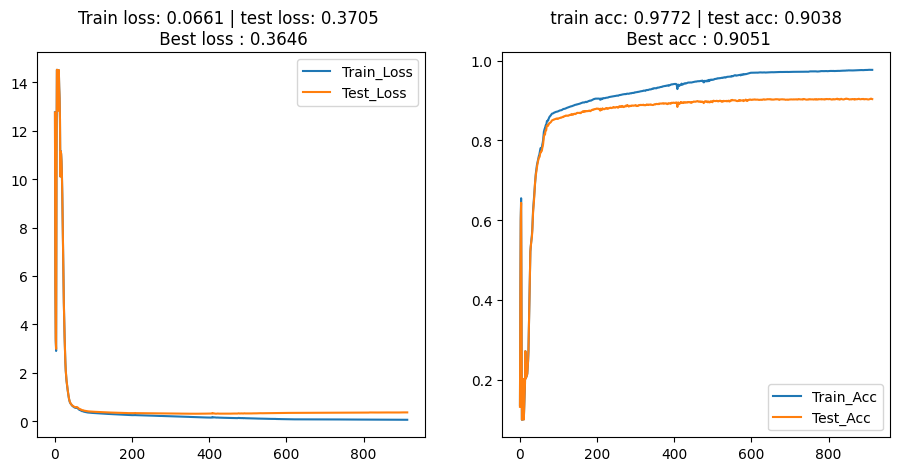

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize =(11,5))
plt.subplot(1,2,1)
plt.title(f"Train loss: {loss:.4f} | test loss: {float(test_loss):.4f} \n Best loss : {float(best_loss):.4f}")
plt.plot(train_loss_list,label="Train_Loss")
plt.plot(test_loss_list,label="Test_Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title(f" train acc: {float(train_acc):.4f} | test acc: {float(test_acc):.4f} \n Best acc : {float(best_acc):.4f}")
plt.plot(train_acc_list,label="Train_Acc")
plt.plot(test_acc_list,label ="Test_Acc")
plt.legend()
plt.show()

Class 0: 0.8458
Class 1: 0.9909
Class 2: 0.8387
Class 3: 0.8882
Class 4: 0.8567
Class 5: 0.9730
Class 6: 0.7497
Class 7: 0.9482
Class 8: 0.9749
Class 9: 0.9695
Class macro avg: 0.9036
Class weighted avg: 0.9036

최저 정확도를 갖는 클래스: Class 6 (0.7497)
최고 정확도를 갖는 클래스: Class 1 (0.9909)


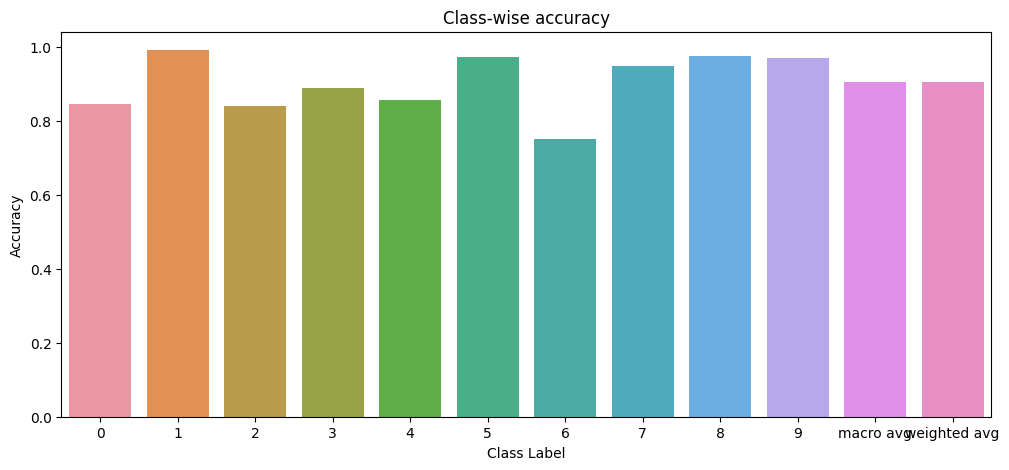

Class 0: Precision = 0.8458, Recall = 0.8560
Class 1: Precision = 0.9909, Recall = 0.9750
Class 2: Precision = 0.8387, Recall = 0.8530
Class 3: Precision = 0.8882, Recall = 0.9220
Class 4: Precision = 0.8567, Recall = 0.8430
Class 5: Precision = 0.9730, Recall = 0.9730
Class 6: Precision = 0.7497, Recall = 0.7220
Class 7: Precision = 0.9482, Recall = 0.9700
Class 8: Precision = 0.9749, Recall = 0.9710
Class 9: Precision = 0.9695, Recall = 0.9530
Class macro avg: Precision = 0.9036, Recall = 0.9038
Class weighted avg: Precision = 0.9036, Recall = 0.9038

전체 평균 정밀도: 0.9036
전체 평균 재현율: 0.9038


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측 생성
y_pred = np.argmax(network.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# 분류 보고서 생성
report = classification_report(y_true, y_pred, output_dict=True)


# 클래스별 정확도 추출
class_accuracy = {class_label: metrics['precision'] for class_label, metrics in report.items() if isinstance(metrics, dict)}

for class_label, accuracy in class_accuracy.items():
    print(f'Class {class_label}: {accuracy:.4f}')

# 최저 정확도를 갖는 클래스 찾기
min_accuracy_class = min(class_accuracy, key=class_accuracy.get)
max_accuracy_class = max(class_accuracy, key=class_accuracy.get)

print(f'\n최저 정확도를 갖는 클래스: Class {min_accuracy_class} ({class_accuracy[min_accuracy_class]:.4f})')
print(f'최고 정확도를 갖는 클래스: Class {max_accuracy_class} ({class_accuracy[max_accuracy_class]:.4f})')

# 시각화
plt.figure(figsize=(12, 5))
sns.barplot(x=list(class_accuracy.keys()), y=list(class_accuracy.values()))
plt.title('Class-wise accuracy')
plt.xlabel('Class Label')
plt.ylabel('Accuracy')
plt.show()

# 클래스별 정밀도와 재현율 출력
for class_label, metrics in report.items():
    if isinstance(metrics, dict):
        precision = metrics['precision']
        recall = metrics['recall']
        print(f'Class {class_label}: Precision = {precision:.4f}, Recall = {recall:.4f}')

# 전체 평균 정밀도와 재현율 출력
print(f'\n전체 평균 정밀도: {precision:.4f}')
print(f'전체 평균 재현율: {recall:.4f}')


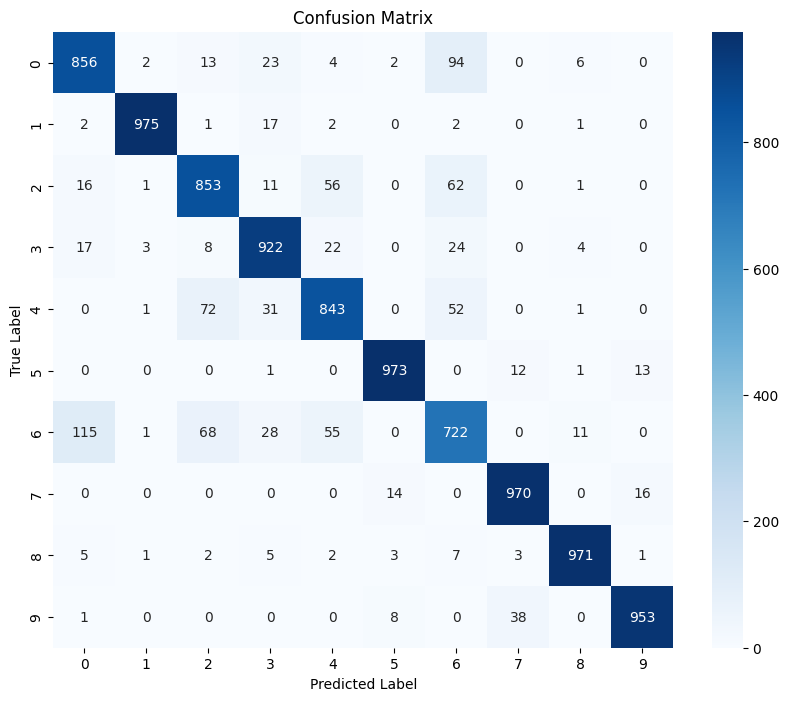

AttributeError: 'MultiLayerNetExtend' object has no attribute 'predict_proba'

In [29]:

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import roc_curve, auc

# 각 클래스에 대한 ROC Curve 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), network.predict_proba(x_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc


# OneVsRestClassifier로 감싸기
classifier = OneVsRestClassifier(network)

# 모델 학습
classifier.fit(x_train, y_train)

# decision function을 사용하여 각 클래스에 대한 확률 예측
y_score = classifier.decision_function(x_test)

# Assuming `network` is an instance of MultiLayerNetExtend
# You need to replace it with your actual instance.
num_classes=10
# 각 클래스에 대한 ROC 곡선 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    # predict 메서드를 사용하여 원시 점수를 가져온 다음 softmax를 적용합니다.
    y_score = softmax(network.predict(x_test), axis=1)
    
    # 양성 클래스 (클래스 i)에 대한 확률 추출
    y_prob = y_score[:, i]
    
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 시각화
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('각 클래스에 대한 ROC 곡선')
plt.xlabel('거짓 양성 비율')
plt.ylabel('진짜 양성 비율')
plt.legend()
plt.show()


## 가중치 저장

In [ ]:
import numpy as np
from time import time

# 가중치를 저장합니다.
np.save(f'2023-11-21_{hidden_size}.npy', network.params)


## 가중치 불러오기 방법

In [ ]:
# import numpy as np

# # 가중치를 불러옵니다.
# weights = np.load('weights.npy', allow_pickle=True).item()

# # 불러온 가중치를 모델에 적용합니다.
# network.params = weights
